# Heterogeneity Classifier

This tutorial demonstrates how we can use scale-independent porosity variance to classify a given sample as homogeneous or heterogeneous.

___

## Import packages

In [1]:
from dpm_tools.io import read_image
from dpm_tools.metrics import heterogeneity_curve
from dpm_tools.visualization import  plot_heterogeneity_curve
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

[21:29:02] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=49500;file:///opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=642406;file:///opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

### Load and visualize data

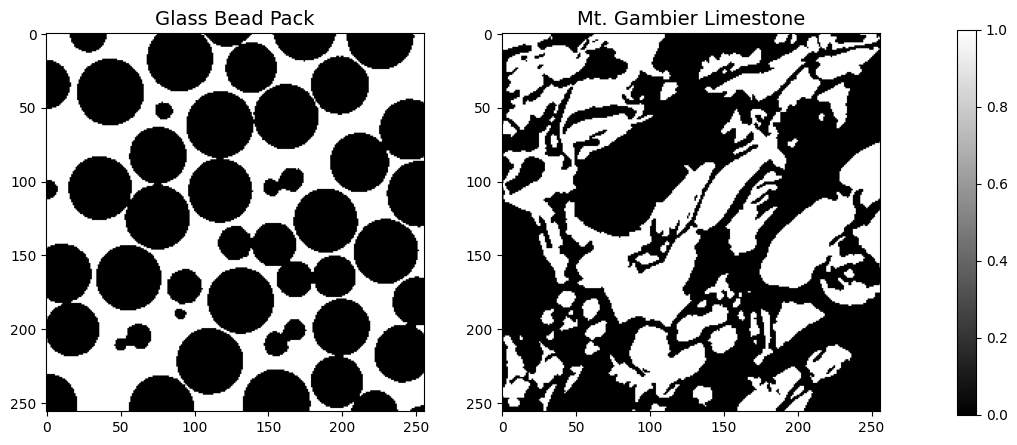

In [2]:
datapath = Path('../../../_static')
beadpack = read_image(datapath / 'beadpack.tif')
gambier = read_image(datapath / 'mtgambier.tif')

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])


im1 = ax1.imshow(beadpack[0,:,:], cmap='gray')
im2 = ax2.imshow(gambier[0,:,:], cmap='gray')

fig.colorbar(im1, cax=cax)

ax1.set_title('Glass Bead Pack',fontsize=14)
ax2.set_title('Mt. Gambier Limestone',fontsize=14)

plt.show()

### Scale-independent Variance

In [3]:
results = {'beadpack': {}, 'gambier': {}}

results['beadpack']['radii'], results['beadpack']['variance'] = heterogeneity_curve(beadpack)
results['gambier']['radii'], results['gambier']['variance'] = heterogeneity_curve(gambier)


### Plot the Results

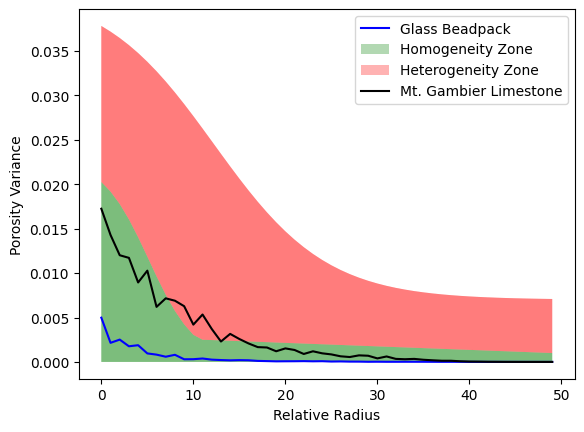

In [4]:
fig, ax = plot_heterogeneity_curve(results['beadpack']['radii'], results['beadpack']['variance'], color='blue', label='Glass Beadpack')
fig, ax = plot_heterogeneity_curve(results['gambier']['radii'], results['gambier']['variance'], fig=fig, ax=ax, color='black', label='Mt. Gambier Limestone')

plt.legend()
plt.show()

### Scoring the Result


In [5]:
def sigmoid(x):
    """
    Sigmoid function
    """

    return 1 / (1 + np.exp(-x))

def heterogeneity_score(variances) -> float:
    """
    Assign a heterogeneity score to the heterogeneity curve based on the number of points above the homogeneous/heterogeneous threshold.
    
    Parameters:
    variances (np.ndarray): The porosity variance values from the heterogeneity curve
    
    Returns:
    float: The heterogeneity score for the given heterogeneity curve. 0 = homogeneous, 1 = heterogeneous
    """
    x = np.linspace(-2, 17, len(variances))
    bound = (0.023 * (1 - sigmoid(x)))
    bnd = bound[bound <= 0.0025]
    bound[bound <= 0.0025] = np.linspace(0.0025, 0.001, len(bnd))
    
    x2=np.linspace(-2, 6, len(variances))
    vv=((0.035 * (1 - sigmoid(x2)))) + 0.007
    wts = vv / vv.sum()
    
    r = wts * (variances > bound)

    return r.sum()

In [6]:
beadpack_score = heterogeneity_score(results['beadpack']['variance'])
gambier_score = heterogeneity_score(results['gambier']['variance'])

print(f"Heterogeneity Score for Glass Bead Pack: {beadpack_score :.3f}")

print(f"Heterogeneity Score for Mt. Gambier Limestone: {gambier_score:.3f}")

Heterogeneity Score for Glass Bead Pack: 0.000
Heterogeneity Score for Mt. Gambier Limestone: 0.220
